## Importing all libraries

In [518]:
import os
os.environ['MUJOCO_GL'] = 'glfw'
import mujoco

import ffmpeg

print('Checking that the dm_control installation succeeded...')
try:
  from dm_control import suite
  env = suite.load('cartpole', 'swingup')
  pixels = env.physics.render()
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')
else:
  del pixels, suite


%load_ext autoreload

Checking that the dm_control installation succeeded...
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [519]:
#@title All `dm_control` imports required for this tutorial

# The basic mujoco wrapper.
from dm_control import mujoco as dm_mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation

# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import IPython.display as display
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# # Inline video helper function
# if os.environ.get('COLAB_NOTEBOOK_TEST', False):
#   # We skip video generation during tests, as it is quite expensive.
#   display_video = lambda *args, **kwargs: None
# else:
def display_video(frames, framerate=30):
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)  # Switch back to the original backend.
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  display.display(HTML(anim.to_html5_video()))

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

Import the robot assets needed for the task first

## Make Classes to store each Robot Model
Attach the Robot Model to the main model

In [520]:
"""
Defines the UR5E_Robotiq arm
"""
class UR5E_Robotiq:
    def __init__(self, model_name : str, arm_pos : list = [-0.2, -0.2, 0.15], 
                 body_xml_file : str = 'assets/robotiq/robotiq.xml',
                 gripper_xml_file: str = 'assets/robotiq/robotiq_gripper.xml'
                ):
                self.model = mjcf.RootElement(model=model_name)
                
                #Include the required assets
                self.robotiq_assets = robotiq_assets
                self.robotiq_assets.model = model_name
                self.model.attach(self.robotiq_assets)
                
                #Add the robotiq arm
                self.arm = model.worldbody.add('body', name="ur5e_robotiq", pos=arm_pos)
                self.arm.add('joint', name="ur5e_0_base_joint", type="slide", axis="1 0 0", range="-1.3 1.3", armature="1", damping="1000") 
                self.body_site = self.arm.add('site', name="robotiq_base_attachment_site") #Add a site to attach the rest of the components

                self.body = mjcf.from_path(body_xml_file)
                self.body_site.attach(self.body) #Attach the rest of the components of the arm
                
                #Attaching the gripper
                self.gripper = mjcf.from_path(gripper_xml_file)
                self.gripper_site = self.model.find('site', 'ur5e_0_attachment_site')
                self.gripper_site.attach(self.gripper)


""" 
Defines the Panda Arm 
"""
class Panda:
    def __init__(self, model_name: str, arm_pos = [0.6, 1.02, 0.1], 
                 xml_file : str = 'envs/assets/panda/panda.xml'
                ):
                self.model = mjcf.RootElement(model=model_name)

                #Include the required files/assets
                # self.body = self.model.worldbody.add('body', name='panda', pos = arm_pos)
                self.panda_site = self.model.worldbody.add('site', name='panda', pos = arm_pos, size =[0.001, 0.001, 0.001])

                #Add a site for attachment of xml file
                # self.panda_site = self.body.add('site', name="panda_site", size="0.001 0.001 0.001")
                panda_obj = mjcf.from_path(xml_file)
                self.panda_site.attach(panda_obj)

        

# Defining the Task

In [805]:
TASK_OBJECTS = [["key_card", "right_door_handle", "table_top"]]

PANDA_CONSTANTS=dict(
    name="panda",
    all_joint_names=[
        "base_joint",
        "joint1",
        "joint2",
        "joint3",
        "joint4",
        "joint5",
        "joint6",
        "joint7",
        "finger_joint1",
        "finger_joint2",
        ],
    ik_joint_names=[
        "base_joint",
        "joint1",
        "joint2",
        "joint3",
        "joint4",
        "joint5",
        "joint6",
        "joint7", 
    ],
    arm_joint_names=[
        "joint1",
        "joint2",
        "joint3",
        "joint4",
        "joint5",
        "joint6",
        "joint7",
        ],
    actuator_info={
        "base_joint":"panda_base",
        "joint1": "actuator1",
        "joint2": "actuator2",
        "joint3": "actuator3",
        "joint4": "actuator4",
        "joint5": "actuator5",
        "joint6": "actuator6",
        "joint7": "actuator7",
        "split": "actuator8",
    },
    grasp_actuator="panda_gripper_actuator",
    all_link_names=[
        "link0",
        "link1",
        "link2",
        "link3",
        "link4",
        "link5",
        "link6",
        "link7",
        "hand",
        "left_finger",
        "right_finger",
        ],
    arm_link_names=[
        "",
        "link0",
        "link1",
        "link2",
        "link3",
        "link4",
        "link5",
        "link6",
        "link7",
        ],
    ee_link_names=["hand", "left_finger", "right_finger"],
    base_joint="base_joint",
    ee_site_name="ee",
    weld_body_name="panda",
)

class DoorCabinet():
    def __init__(self, filepath = None, **kwargs):
        
        # super(DoorCabinet, self).__init__(filepath, 
        #                                   task_objects=TASK_OBJECTS, 
        #                                   **kwargs
        #                                 )
        
        self.model = mjcf.RootElement(model="doorcabinet")

        #Set the global_params
        self.global_params()
        #Set default classes
        self.set_dclasses()
        #Build the scene
        self.build_scene()
        
        #Add the robots
        panda_config = PANDA_CONSTANTS.copy()
        self.add_robots()

        #If add cameras:
        self.add_cameras()

        self.physics = mjcf.Physics.from_mjcf_model(self.model)
        
        self.door_name = "cabinet/right_door_handle"
        self.cabinet_pos = self.physics.data.body("cabinet/cabinet").xpos.copy()
        self.open_door_pose = self.compute_door_open_pose() #[3, 4]

        
    def global_params(self):
        #Compiler options
        self.model.compiler.angle = 'radian'
        self.model.compiler.autolimits = 'true'

        #Visual options
        self.model.visual.headlight.diffuse = [0.6, 0.6, 0.6] #Can use a list format or a string format
        self.model.visual.headlight.ambient=[0.1, 0.1, 0.1]
        self.model.visual.headlight.specular=[0, 0, 0]
        self.model.visual.rgba.haze = "0.15 0.25 0.35 1"
        self.model.visual.__getattr__('global').azimuth = 120 #Only way to access global attribute since gloabl is a Python keyword
        self.model.visual.__getattr__('global').elevation = -20
        self.model.visual.__getattr__('global').offwidth = 2000
        self.model.visual.__getattr__('global').offheight = 2000
        self.model.visual.quality.shadowsize = 4096

    def set_dclasses(self):
        #Default class values
        self.obj_visual_class = self.model.default.add('default', dclass="object_visual")
        self.obj_site_class = self.model.default.add('default', dclass='object_sites')
        self.obj_collision_class = self.model.default.add('default', dclass='object_collision')
        # obj_hingecabinet = self.model.default.add('default', dclass="hingecabinet")

        self.obj_visual_class.geom.type = 'mesh'
        self.obj_visual_class.geom.conaffinity = '0'
        self.obj_visual_class.geom.contype = '0'
        self.obj_visual_class.geom.group = '1'
        self.obj_visual_class.geom.mass = '0.00001'

        #add('site', type='cylinder', size='0.003 0.006', group=3)
        self.obj_site_class.site.type = 'cylinder'
        self.obj_site_class.site.size = '0.003 0.006'
        self.obj_site_class.site.group = 3           

        # <geom density="500" rgba="0.8 0.8 0.8 0.9" group="3"/>
        self.obj_collision_class.geom.density = '500'
        self.obj_collision_class.geom.rgba = '0.8 0.8 0.8 0.9'
        self.obj_collision_class.geom.group = 3

    def build_scene(self):
        #Floor and initial light
        self.model.worldbody.add('light', pos="0 0 1.5", dir="0 0 -1", directional="true")

        self.groundplane_texture = self.model.asset.add('texture', type="2d", name="groundplane", builtin="checker", mark="edge", rgb1="0.2 0.3 0.4", rgb2="0.1 0.2 0.3", markrgb="0.8 0.8 0.8", width="300", height="300")
        self.groundplane_mat = self.model.asset.add('material', name="groundplane", texture="groundplane", texuniform="true", texrepeat="2 2", reflectance="0.2")
        self.groundplane = self.model.worldbody.add('geom', name="floor", pos="0 0 -0.5", size="0 0 0.05", type="plane", material="groundplane")

        #Adding the table box
        self.table_box = self.model.worldbody.add('body', name="table", pos="0 0.5 0")
        self.table_box.add('geom', name="table_collision", pos="0 0 0.1", size="1.6 .5 0.05", type="box", friction="1 0.005 0.0001")

        self.table_top = self.table_box.add('body', name="table_top", pos="0 0 0.1")
        self.table_top.add('geom', name="table_top", size="1.6 0.4 0.05", type="box", conaffinity="0", contype="0", group="1")
        # table_top.add('site', name="table_top", size="0.001 0.001 0.001", class_="site_top")

        self.table_box.add('geom', name="table_left", pos="-1.63 0 1", size="0.02 1.6 1.5", rgba="1 1 1 0", type="box")
        self.table_box.add('geom', name="table_right", pos="1.63 0 1", size="0.02 1.6 1.5", rgba="1 1 1 0", type="box")
        self.table_box.add('geom', name="table_front", pos="0 1.63 1", size="1.7 0.02 1.5", rgba="1 1 1 0", type="box")
        self.table_box.add('geom', name="table_back", pos="0 -1.63 1", size="1.7 0.02 1.5", rgba="1 1 1 0", type="box");

        #Adding a key card on the table
        self.key_card = self.model.worldbody.add('body', name="keycard", pos="0.5 0.5 0.15")

        #Can also do add_free_joint()
        self.key_card.add('freejoint', name="keycard_joint") #, type="free", name="keycard_joint", pos="0 0 0", axis="0 0 1")
        self.key_card.add('geom', name='keycard', type="box", rgba="0. 0. 0. 1", size="0.05 0.1 0.01")

        #Add the cabinet    
        self.cabinet_path = "rocobench/envs/assets/cabinet/cabinet_mjcf.xml"
        self.cabinet =  mjcf.from_file(self.cabinet_path)
        self.cabinet.model = "cabinet"
        self.model.attach(self.cabinet)

        #Add the camera
        self.camera = self.model.worldbody.add('camera', name='my_camera', pos="2.1 -0.15 1.731", xyaxes="0.487 0.874 0.000 -0.500 0.278 0.820")

    def add_cameras(self):
        self.model.worldbody.add('camera', mode="fixed", name='face_panda1', pos="0.062 -2.806 0.768", xyaxes="1.000 0.009 -0.000 0.001 -0.131 0.991")
        self.model.worldbody.add('camera', mode="fixed", name='face_panda2', pos="0.084 3.711 0.772", xyaxes="-1.000 0.016 0.000 0.002 0.111 0.994")
        self.model.worldbody.add('camera', mode="fixed", name='top_cam', pos="-0.001 0.652 2.057", xyaxes="-1.000 -0.000 -0.000 0.000 -1.000 0.019")
        self.model.worldbody.add('camera', mode="fixed", name='right_cam', pos="1.873 0.605 0.926", xyaxes="0.014 1.000 0.000 -0.242 0.003 0.970")
        self.model.worldbody.add('camera', mode="fixed", name='left_cam', pos="-1.873 0.605 0.926", xyaxes="-0.000 -1.000 0.000 0.177 -0.000 0.984")
        self.model.worldbody.add('camera', name='teaser', pos="2.675 -0.747 1.997", xyaxes="0.496 0.869 -0.000 -0.429 0.245 0.869")
        self.model.worldbody.add('camera', name='video', pos="1.957 -0.281 1.731", xyaxes="0.487 0.874 0.000 -0.500 0.278 0.820")

    def render_scene(self, ctrl: dict, duration, framerate, cam: str, width=800, height=800):
        # Simulate and display video.
        frames = []
        self.physics.reset()  # Reset to keyframe 0 (load a saved state).
        while self.physics.data.time < duration:
            self.physics.data.ctrl[ctrl["ctrl_idxs"]] = ctrl["ctrl_vals"]
            self.physics.step()
            if len(frames) < (self.physics.data.time) * framerate:
                pixels = self.physics.render(camera_id=cam, width=width, height=height)
                frames.append(pixels)

        display_video(frames, framerate)
        
    def add_robots(self):
        #Generalize for multiple robots/arms
        # self.panda_arm1 = Panda("panda1", arm_pos=[0.6, 1.02, 0.1], xml_file='rocobench/envs/assets/panda/panda.xml')
        # self.panda_arm2 = Panda("panda2", arm_pos=[0.6, -0.05, 0.1], xml_file='rocobench/envs/assets/panda/panda.xml')
        
        self.panda_arm1 = mjcf.from_path('rocobench/envs/assets/panda/panda.xml')
        self.panda_arm1.model = "panda1"

        self.panda_arm2 = mjcf.from_path('rocobench/envs/assets/panda/panda.xml')
        self.panda_arm2.model = "panda2"    
        
        panda_arm1_site = self.model.worldbody.add('site', name='panda1', pos=[0.2, 1.15, 0.1], size=[0.001, 0.001, 0.001])
        panda_arm2_site = self.model.worldbody.add('site', name='panda2', pos=[0.6, -.15, 0.1], size=[0.001, 0.001, 0.001])
        
        panda_arm1_site.attach(self.panda_arm1)
        panda_arm2_site.attach(self.panda_arm2)

        #Add weld connections
        self.model.equality.add("weld", name="door_handle_panda", body1="cabinet/right_door_handle", body2="panda1/palm", relpose=[0,0, 0, 1, 0, 0, 0], active=False)
        self.model.equality.add("weld", name="keycard_panda", body1="keycard", body2="panda2/palm", relpose=[0,0, 0, 1, 0, 0, 0], active=False)

        
    def compute_door_open_pose(self, door_name: str = "cabinet/right_door_handle"):
        physics = self.physics.copy(share_model=True)
        # if door_name == "left_door_handle":
        #     qpos_slice = self.physics.named.data.qpos._convert_key("leftdoorhinge")
        #     if self.cabinet_pos[0] > 0:
        #         physics.data.qpos[qpos_slice.start] = -2.2
        #     else:
        #         physics.data.qpos[qpos_slice.start] = -2.6
        # elif door_name == "right_door_handle":
        qpos_slice = self.physics.named.data.qpos._convert_key("cabinet/rightdoorhinge")
        if self.cabinet_pos[0] > 0:
            physics.data.qpos[qpos_slice.start] = 1.8    
        else:
            physics.data.qpos[qpos_slice.start] = 1.
        # else:
        #     raise NotImplementedError
        physics.forward()
        desired_handle_pose = np.concatenate(
            [physics.data.body(door_name).xpos, physics.data.body(door_name).xquat]
        ) 
        # img = physics.render(camera_id="teaser")
        # plt.imshow(img)
        # plt.show()
        del physics 
        return desired_handle_pose   

doorcabinet = DoorCabinet()

In [806]:
doorcabinet.physics.data.body("cabinet/cabinet").xpos

array([-0.7 ,  0.5 ,  0.47])

In [807]:
from rocobench.envs.robot import SimRobot

#Handle Configs to work with SimRobot and MultiArmRRT
def append_panda_names(name,panda_constants):
    constants = dict()
    constants["name"] = name
    for key, value in panda_constants.items():
        #print(key)
        if key=='name':
            continue
        if key == "actuator_info":
            constants[key] = {name + "/" + x: name + "/" + y for x, y in value.items()}
        elif isinstance(panda_constants[key],str):
            constants[key]=name+'/'+value
        else:
            constants[key] = [name + "/" + x for x in value]

    return constants

panda1_constants = append_panda_names("panda1",PANDA_CONSTANTS)
panda2_constants = append_panda_names("panda2",PANDA_CONSTANTS)

panda1=SimRobot(physics=doorcabinet.physics,use_ee_rest_quat=False,**panda1_constants)
panda2=SimRobot(physics=doorcabinet.physics,use_ee_rest_quat=False,**panda2_constants)
robots={'panda1':panda1,'panda2':panda2}

panda1.ik_joint_names

['panda1/base_joint',
 'panda1/joint1',
 'panda1/joint2',
 'panda1/joint3',
 'panda1/joint4',
 'panda1/joint5',
 'panda1/joint6',
 'panda1/joint7']

In [808]:
# doorcabinet.physics.named.data.qpos
# doorcabinet.physics.named.model.eq_active

print(doorcabinet.physics.named.data.qpos["keycard_joint"])

[0.5  0.5  0.15 1.   0.   0.   0.  ]


# Rendering the final environment

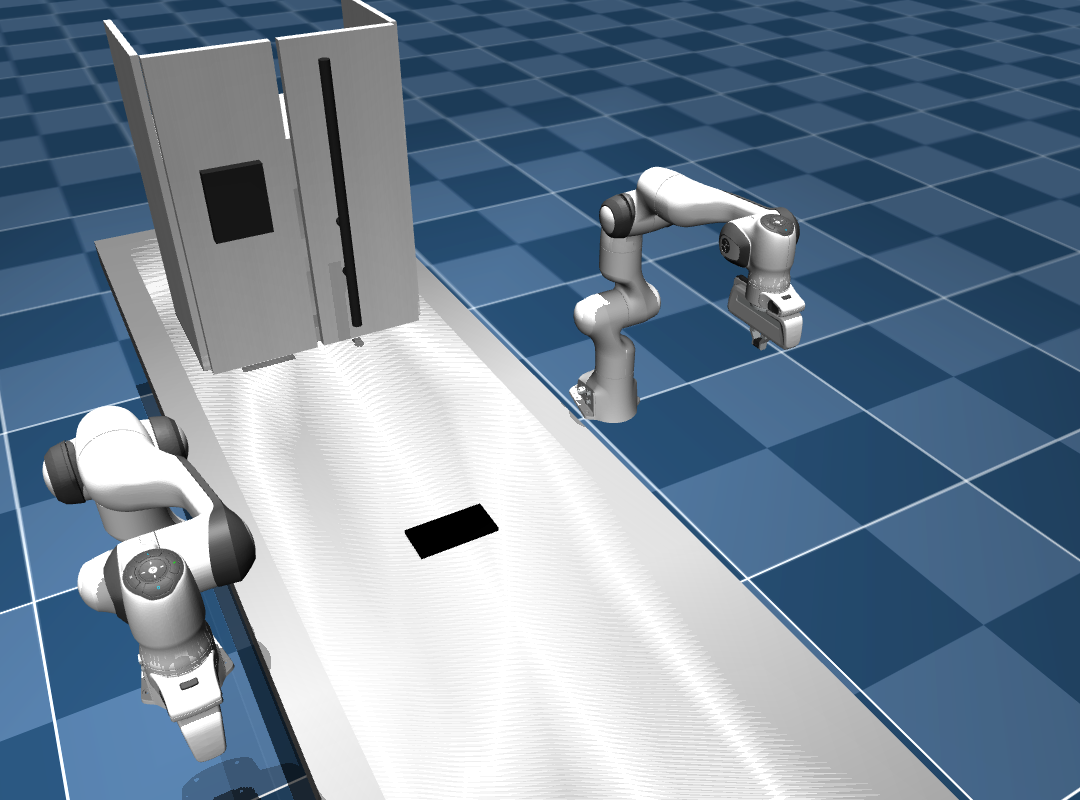

In [809]:
def reset_to_home_pose(physics, joint_ids, render=False):
    physics.reset_context()

    physics.named.data.qpos["keycard_joint"] = [0.5, 0.5, 0.15, 1., 0., 0., 0.]
    physics.named.model.eq_active["keycard_panda"] = False
    physics.named.model.eq_active["door_handle_panda"] = False
    # qpos="0 0 0 -1.57079 0 1.57079 -0.7853 0.04 0.04"
    physics.data.qpos[joint_ids["panda1"]["qpos"] + joint_ids["panda2"]["qpos"]] = [0., 0., 0., 0., -1.57079, 0, 1.57079, -0.7853]*2 
    physics.step()

    if render:
        img = PIL.Image.fromarray(physics.render(camera_id=0, width=1080, height=800))
        return img
    
    return None

joint_ids = {"panda1": {"qpos":panda1.joint_idxs_in_qpos, "ctrl":panda1.joint_idxs_in_ctrl}, 
             "panda2": {"qpos":panda2.joint_idxs_in_qpos, "ctrl":panda2.joint_idxs_in_ctrl}
            }

reset_to_home_pose(doorcabinet.physics, joint_ids, True)
# doorcabinet.physics.step()
# PIL.Image.fromarray(doorcabinet.physics.render(camera_id=0, width = 1080, height = 800))

## POLICY Section
Input a pair of target pose for both robot, then use the planner to generate motion traj. for both robots to reach the target pose

In [810]:
# ## Move Stuff in Sim to test and work ##
# # doorcabinet.physics.named.data.qpos

#Define target poses and orientations
keycard_pos = doorcabinet.physics.named.data.xpos["keycard"]
keycard_quat = np.array([ 0., 1., 0., 0. ])

doorhinge_pos = doorcabinet.physics.named.data.xpos["cabinet/right_door_handle"]
doorhinge_quat = np.array([ 0., -0.707, 0., 0.707 ])


pre_grasp_poses = {"doorhinge": {"pos": doorhinge_pos + np.array([.1, 0., 0.1 ]), "quat": doorhinge_quat}, 
                    "keycard": {"pos": keycard_pos + np.array([0.0, 0.0, 0.14]), "quat": keycard_quat}    
                }

doorhinge_result = panda1.solve_ik(doorcabinet.physics, pre_grasp_poses["doorhinge"]["pos"], pre_grasp_poses["doorhinge"]["quat"])
print(doorhinge_result)

keycard_result = panda2.solve_ik(doorcabinet.physics, pre_grasp_poses["keycard"]["pos"], pre_grasp_poses["keycard"]["quat"])
print(keycard_result)


IKResult(qpos=array([ 5.00000000e-01,  5.00000000e-01,  1.50051438e-01,  1.00000000e+00,
       -4.12211519e-19,  9.96798797e-18,  0.00000000e+00,  0.00000000e+00,
       -6.54297368e-01, -5.61902291e-01,  2.73176993e-01, -5.61466076e-01,
       -1.82379993e+00, -1.22110299e+00,  1.22811981e+00, -2.72550234e-01,
        2.27799688e-05, -2.27799688e-05, -1.14287599e-05, -2.16391443e-06,
       -8.63478707e-05, -2.54187264e-06, -1.57109323e+00, -8.29253663e-07,
        1.57149195e+00, -7.85660536e-01,  2.27799688e-05, -2.27799688e-05]), err_norm=1.0451876655685028e-15, steps=6, success=True)
IKResult(qpos=array([ 5.00000000e-01,  5.00000000e-01,  1.50051438e-01,  1.00000000e+00,
       -4.12211519e-19,  9.96798797e-18,  0.00000000e+00,  0.00000000e+00,
       -1.14287599e-05, -2.16391443e-06, -8.63478707e-05, -2.54187264e-06,
       -1.57109323e+00, -8.29253663e-07,  1.57149195e+00, -7.85660536e-01,
        2.27799688e-05, -2.27799688e-05, -3.38367956e-01,  9.73962747e-01,
        7.6806

## Implementing RRT 

In [811]:
### Visualizing the data ###
%autoreload 2
from rocobench.rrt_multi_arm import MultiArmRRT

In [812]:
doorcabinet.physics.named.data.xpos

FieldIndexer(xpos):
                               x         y         z         
 0                     world [ 0         0         0       ]
 1                     table [ 0         0.5       0       ]
 2                 table_top [ 0         0.5       0.1     ]
 3                   keycard [ 0.5       0.5       0.15    ]
 4                  cabinet/ [ 0         0         0       ]
 5           cabinet/cabinet [-0.7       0.5       0.47    ]
 6      cabinet/cabinet_body [-0.7       0.5       0.47    ]
 7  cabinet/cabinet_leftdoor [-0.5       0.16      0.47    ]
 8        cabinet/key-reader [-0.5       0.16      0.47    ]
 9 cabinet/cabinet_rightdoor [-0.5       0.84      0.47    ]
10 cabinet/right_door_handle [-0.4       0.61      0.47    ]
11                   panda1/ [ 0.2       1.15      0.1     ]
12              panda1/link0 [ 0.2       1.15      0.1     ]
13              panda1/link1 [ 0.2       1.15      0.433   ]
14              panda1/link2 [ 0.2       1.15      0.433   ]
15 

In [816]:
rrt = MultiArmRRT(doorcabinet.physics, 
                  robots,
                  allowed_collision_pairs=[(1, 9), (1, 3), (1, 4), (1, 6), (4, 21), (4, 22), (4, 23)], 
                                          #(2,4), (2, 5), (2, 6)], 
                                           #(17, 19), (17, 20), (17, 21), (17, 22),
                                        #    (24, 30), (25, 30), (25, 31), (25, 32), (25, 29), (26, 28), (26, 29), (26, 32), (26, 29),
                                        #    (26, 31), (29, 32), (29, 33), (29, 31),
                                        #    (24, 28), (24, 29), (24, 32), (24, 29), (27, 32), (27, 29), (27, 30), (27, 31)],
                  seed = 391)

#Ensuring No Initial Collisions
start_qpos = doorcabinet.physics.named.data.qpos[panda1.joint_idxs_in_qpos + panda2.joint_idxs_in_qpos].copy()

rrt.check_collision(start_qpos, physics=doorcabinet.physics)


False

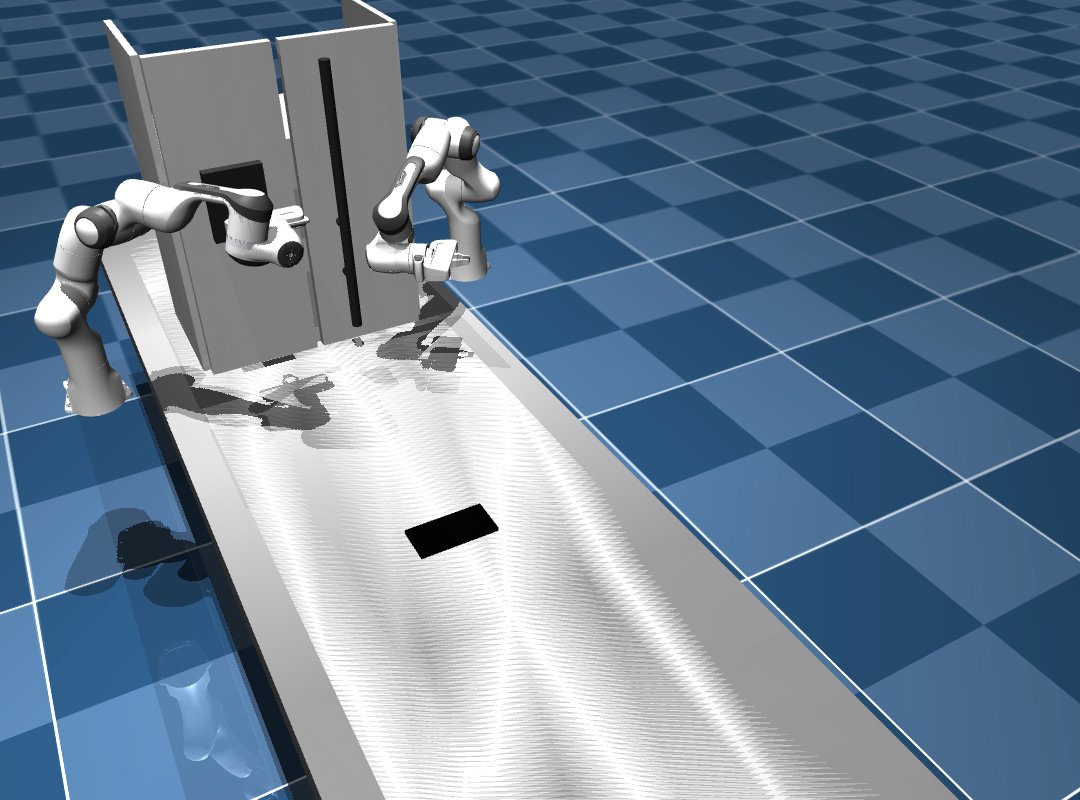

In [817]:
#Goal Pos: Keycard and DoorHinge
p1_goal = rrt.solve_ik(doorcabinet.physics, 
                       site_name=panda1.ee_site_name, 
                       target_pos=doorhinge_pos + np.array([.2, 0., 0.1 ]), 
                       target_quat=doorhinge_quat, 
                       joint_names=panda1.ik_joint_names
                    )
p2_goal = rrt.solve_ik(doorcabinet.physics, 
                       site_name=panda2.ee_site_name, 
                       target_pos=keycard_pos + np.array([0.0, 0.0, 0.14]), 
                       target_quat=keycard_quat, 
                       joint_names=panda2.ik_joint_names
                    )

# with doorcabinet.physics.reset_context():
#     q = doorcabinet.physics.data.qpos.copy()
#     q[panda1.joint_idxs_in_qpos] = p1_goal.qpos[panda1.joint_idxs_in_qpos]
#     q[panda2.joint_idxs_in_qpos] = p2_goal.qpos[panda2.joint_idxs_in_qpos]
#     doorcabinet.physics.data.qpos = q
#     doorcabinet.physics.step()
#     img = PIL.Image.fromarray(doorcabinet.physics.render(camera_id=0, width = 1080, height = 800))

# img

#Second Path
keyreader_pos = doorcabinet.physics.named.data.xpos["cabinet/key-reader"]
keyreader_pos += np.array([.25, 0.2, 0.2])
keyreader_quat = np.array([0., -0.707, 0., 0.707])

p2_second_goal = rrt.solve_ik(doorcabinet.physics, 
                       site_name=panda2.ee_site_name, 
                       target_pos= keyreader_pos, 
                       target_quat=keyreader_quat, 
                       joint_names=panda2.ik_joint_names
                    )


# with doorcabinet.physics.reset_context():
#     q = doorcabinet.physics.data.qpos.copy()
#     q[panda1.joint_idxs_in_qpos] = p1_goal.qpos[panda1.joint_idxs_in_qpos]
#     q[panda2.joint_idxs_in_qpos] = p2_second_goal.qpos[panda2.joint_idxs_in_qpos]
#     doorcabinet.physics.data.qpos = q
#     doorcabinet.physics.step()
#     img = PIL.Image.fromarray(doorcabinet.physics.render(camera_id=0, width = 1080, height = 800))

# img

#Third Path Open the Door
p1_second_goal = rrt.solve_ik(doorcabinet.physics, 
                       site_name=panda1.ee_site_name, 
                       target_pos= doorcabinet.open_door_pose[:3], 
                       target_quat=doorcabinet.open_door_pose[3:], 
                       joint_names=panda1.ik_joint_names
                    )

with doorcabinet.physics.reset_context():
    q = doorcabinet.physics.data.qpos.copy()
    q[panda1.joint_idxs_in_qpos] = p1_second_goal.qpos[panda1.joint_idxs_in_qpos]
    q[panda2.joint_idxs_in_qpos] = p2_second_goal.qpos[panda2.joint_idxs_in_qpos]
    doorcabinet.physics.data.qpos = q
    doorcabinet.physics.step()
    img = PIL.Image.fromarray(doorcabinet.physics.render(camera_id=0, width = 1080, height = 800))

img


Planning the Path using rrt.plan()

RRT succeeded: ReasonDirect_time2.2568650245666504_iter1
RRT succeeded: ReasonDirect_time4.262120723724365_iter1
{('cabinet/', 'panda1/')}


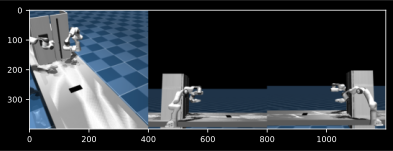

<key name='rrt_check' qpos='0.5 0.5 0.15009192116309664 1.0 2.545406130096661e-18 9.307458649952482e-18 1.2240208846492349e-18 -9.472376731434155e-09 -0.9785885514650144 -0.5328680750930255 0.47436865407848877 -0.2961444122586469 -1.7368800923869985 1.5447493948512678 1.3086897776967563 -1.4274118918254128 8.182662054649668e-06 -8.182662054649119e-06 -1.1610944179135168 1.0885321399757324 0.4444159805907799 -0.4056261232209287 -1.3461629188697208 1.5233441942094625 0.7070031640614682 2.068981027477912 3.3875007807257184e-05 -3.387500780725175e-05'/>
ReasonCollisionAtGoal_time0_iter0


In [818]:
reset_to_home_pose(doorcabinet.physics, joint_ids)

first_goal_qpos = np.concatenate([start_qpos[panda1.joint_idxs_in_qpos], p2_goal.qpos[panda2.joint_idxs_in_qpos]])
second_goal_qpos = np.concatenate([p1_goal.qpos[panda1.joint_idxs_in_qpos], p2_second_goal.qpos[panda2.joint_idxs_in_qpos]])
third_goal_qpos = np.concatenate([p1_second_goal.qpos[panda1.joint_idxs_in_qpos], p2_second_goal.qpos[panda2.joint_idxs_in_qpos]])
# print(len(goal_qpos))

# print(first_goal_qpos)

doorcabinet.physics.reset_context()
paths, reason = rrt.plan(start_qpos, first_goal_qpos)
print(reason)

grasp_idx = len(paths) - 1

#Plan second path and append to paths
# second_start_pos = doorcabinet.physics.named.data.qpos[panda1.joint_idxs_in_qpos + panda2.joint_idxs_in_qpos].copy()
second_path, reason = rrt.plan(first_goal_qpos, second_goal_qpos)
print(reason)

paths += second_path
# print(len(paths[0]))      

#Plan third path and append to paths
third_path, reason = rrt.plan(second_goal_qpos, third_goal_qpos)
print(reason)  

Visualizing the Control

In [756]:
doorcabinet.physics.named.data.ctrl

FieldIndexer(ctrl):
 0             panda1/panda_base [-0.783   ]
 1              panda1/actuator1 [-0.579   ]
 2              panda1/actuator2 [ 0.189   ]
 3              panda1/actuator3 [-0.551   ]
 4              panda1/actuator4 [-1.76    ]
 5              panda1/actuator5 [ 0.105   ]
 6              panda1/actuator6 [ 1.92    ]
 7              panda1/actuator7 [-0.372   ]
 8 panda1/panda_gripper_actuator [ 0       ]
 9             panda2/panda_base [-1.16    ]
10              panda2/actuator1 [ 1.09    ]
11              panda2/actuator2 [ 0.445   ]
12              panda2/actuator3 [-0.409   ]
13              panda2/actuator4 [-1.35    ]
14              panda2/actuator5 [ 1.52    ]
15              panda2/actuator6 [ 0.706   ]
16              panda2/actuator7 [ 2.07    ]
17 panda2/panda_gripper_actuator [ 0       ]

In [782]:
frames = []
ctrls=[]
duration=10
framerate=30
control_rate=0.01
doorcabinet.physics.reset()  # Reset state and time

reset_to_home_pose(doorcabinet.physics, joint_ids)
doorcabinet.physics.named.model.eq_active["keycard_panda"] = False

doorcabinet.physics.named.data.ctrl["panda1/panda_gripper_actuator"] = 255
doorcabinet.physics.named.data.ctrl["panda2/panda_gripper_actuator"] = 255

while doorcabinet.physics.data.time < duration:
    idx = int(doorcabinet.physics.data.time/ control_rate)

    if idx >= len(paths):
        idx = len(paths) - 1
    
    if idx >= grasp_idx:
        doorcabinet.physics.named.model.eq_active["keycard_panda"] = True
        doorcabinet.physics.named.data.ctrl["panda2/panda_gripper_actuator"] = 10
        

    t0 = doorcabinet.physics.data.time
    # doorcabinet.physics.data.qpos[panda1.joint_idxs_in_qpos] = paths[idx][:num_panda_joints]
    # panda1_ctrl_vals = doorcabinet.physics.data.qpos[panda1.joint_idxs_in_qpos]
    doorcabinet.physics.data.ctrl[panda1.joint_idxs_in_ctrl + panda2.joint_idxs_in_ctrl] = paths[idx]
    
    



    # doorcabinet.physics.data.qpos[panda2.joint_idxs_in_qpos] = paths[idx][num_panda_joints:]
    # panda2_ctrl_vals = doorcabinet.physics.data.qpos[panda2.joint_idxs_in_qpos]
    # doorcabinet.physics.data.ctrl[panda2.joint_idxs_in_ctrl] = paths[idx][num_panda_joints:]

    # ctrl=np.concatenate((panda1_ctrl_vals,[0],panda2_ctrl_vals,[0]))
    # doorcabinet.physics.data.ctrl=ctrl
    while doorcabinet.physics.data.time-t0<control_rate:

        doorcabinet.physics.step()
        if len(frames) < doorcabinet.physics.data.time * framerate:
            pixels = doorcabinet.physics.render(camera_id=0, width=1080,height=800)
            frames.append(pixels)

display_video(frames, framerate)

In [727]:
print(doorcabinet.physics.named.model.eq_active)

FieldIndexer(eq_active):
0          door_handle_panda [0]
1              keycard_panda [1]
2 panda1//unnamed_equality_0 [1]
3 panda2//unnamed_equality_0 [1]


In [712]:
# doorcabinet.physics.named.data.geom_xpos #data.contact.geom1
from typing import Callable, List, Optional, Tuple, Union, Dict, Set, Any, FrozenSet
#Right now only implemented for 2 Panda Robots

class TaskAction():
    def __init__(self, physics, robots: Dict[str, SimRobot] = {}, allowed_collision_pairs = []):
        self.physics = physics
        self.paths = []
        self.robots = robots #Dictionary

        #Modify to take in any number of robots of any type
        self.panda1 = robots["panda1"]
        self.panda2 = robots["panda2"]
        self.joint_ids = {"panda1": {"qpos":panda1.joint_idxs_in_qpos, "ctrl":panda1.joint_idxs_in_ctrl}, 
                          "panda2": {"qpos":panda2.joint_idxs_in_qpos, "ctrl":panda2.joint_idxs_in_ctrl}
                        }

        self.physics.named.model.eq_active["keycard_panda"] = False
        self.physics.named.model.eq_active["door_handle_panda"] = False

        self.rrt = MultiArmRRT( self.physics,
                                self.robots,
                                allowed_collision_pairs=allowed_collision_pairs,
                                seed = 391
                            )
                    
        self.start_qpos = self.physics.named.data.qpos[self.panda1.joint_idxs_in_qpos + self.panda2.joint_idxs_in_qpos].copy()
        # self.panda_path_joint_idxs = len(self.panda1.joint_idxs_in_qpos) #Assume same num joints for each panda arm
        
    def reset_to_home_pose(self, render=False):
        self.physics.reset_context()

        self.physics.named.data.qpos["keycard_joint"] = [0.5, 0.5, 0.15, 1., 0., 0., 0.]
        self.physics.named.model.eq_active["keycard_panda"] = False
        self.physics.named.model.eq_active["door_handle_panda"] = False
        self.physics.data.qpos[self.joint_ids["panda1"]["qpos"] + self.joint_ids["panda2"]["qpos"]] = [0., 0., 0., 0., -1.57079, 0, 1.57079, -0.7853]*2 
        self.physics.step()

        if render:
            img = PIL.Image.fromarray(self.physics.render(camera_id=0, width=1080, height=800))
            return img
        
        return None


    def move_pre_grasp_pose(self, pre_grasp_poses, reset_to_home: bool = False):

        if reset_to_home:
            self.reset_to_home_pose()

        
        doorhinge_pos = pre_grasp_poses["doorhinge"]["pos"]
        doorhinge_quat = pre_grasp_poses["doorhinge"]["quat"]

        keycard_pos = pre_grasp_poses["keycard"]["pos"]
        keycard_quat = pre_grasp_poses["keycard"]["quat"]

        #Find goal qpos for both arms
        p1_goal = self.rrt.solve_ik(self.physics, 
                       site_name=self.panda1.ee_site_name, 
                       target_pos=doorhinge_pos, 
                       target_quat=doorhinge_quat, 
                       joint_names=self.panda1.ik_joint_names
                    )
        p2_goal = self.rrt.solve_ik(self.physics, 
                       site_name=self.panda2.ee_site_name, 
                       target_pos=keycard_pos, 
                       target_quat=keycard_quat, 
                       joint_names=self.panda2.ik_joint_names
                    )

        # #Ensure the arm is at home pose before calling move_pre_grasp
        # reset_to_home_pose(self.physics, self.panda1.joint_idxs_in_ctrl, self.panda2.joint_idxs_in_ctrl)

        goal_qpos = np.concatenate([p1_goal.qpos[self.panda1.joint_idxs_in_qpos], p2_goal.qpos[self.panda2.joint_idxs_in_qpos]])

        self.physics.reset_context()
        paths, reason = self.rrt.plan(start_qpos, goal_qpos)

        if paths is None:
            return "Move to pre-grasp pose Failed!"
        else:
            print("Moving to pre-grasp pose")
            self.paths += paths
        
        self.grasp_idx = len(paths) - 1

    #Add robot name as argument to generalize 
    def grasp(self, grasp_object:str, pre_grasp_poses):

    
        #Either control the keycard or the doorhandle not both!
        self.physics.model.eq_active(grasp_object + "_panda")
    
        # self.paths += [None]
        self.grasp_idx = len(self.paths) - 1

        # self.physics.step()

        #Hopefully this succeeds after holding the keycard
        self.move_pre_grasp_pose(pre_grasp_poses)

    def move_to_next_pose(curr_pose, tar_pose):
        #Second Path
        keyreader_pos = self.physics.named.data.xpos["cabinet/key-reader"]
        keyreader_pos += np.array([.25, 0.2, 0.2])
        keyreader_quat = np.array([0., -0.707, 0., 0.707])

        p1_goal = self.rrt.solve_ik(self.physics, 
                site_name=self.panda1.ee_site_name, 
                target_pos=doorhinge_pos, 
                target_quat=doorhinge_quat, 
                joint_names=self.panda1.ik_joint_names
            )

        p2_second_goal = self.rrt.solve_ik(self.physics, 
                            site_name=self.panda2.ee_site_name, 
                            target_pos= keyreader_pos, 
                            target_quat=keyreader_quat, 
                            joint_names=self.panda2.ik_joint_names
                            )
        
        #Moving to keycard reader for now
        second_goal_qpos = np.concatenate([p1_goal.qpos[panda1.joint_idxs_in_qpos], p2_second_goal.qpos[panda2.joint_idxs_in_qpos]])

        self.physics.reset_context()
        paths, reason = self.rrt.plan(start_qpos, second_goal_qpos)

        if paths is None:
            return "Move to next pose Failed!"
        else:
            print("Moving to pre-grasp pose")
            self.paths += paths

    def visualize(self, duration: int = 5, framerate = 30, control_rate = 0.01):
        print("Visualizing the Path")
        frames = []
        ctrls=[]
        
        self.physics.reset()  # Reset state and time

        while self.physics.data.time < duration:
            idx = int(self.physics.data.time/ control_rate)

            if idx >= len(self.paths):
                idx = len(self.paths) - 1

            if(idx >= self.grasp_idx):
                self.physics.named.model.eq_active["keycard_panda"] = True

            t0 = self.physics.data.time
            
            #Modify This!
            self.physics.data.ctrl[self.panda1.joint_idxs_in_ctrl + self.panda2.joint_idxs_in_ctrl] = self.paths[idx]

            while self.physics.data.time - t0 < control_rate:
                self.physics.step()
                if len(frames) < self.physics.data.time * framerate:
                    pixels = self.physics.render(camera_id=0, width=1080,height=800)
                    frames.append(pixels)

        display_video(frames, framerate)


In [713]:
doorcabinet_task = TaskAction(doorcabinet.physics, robots, allowed_collision_pairs = [(1, 9), (1,3),(1, 4), (1, 6)])

# reset_to_home_pose(doorcabinet.physics, panda1.joint_idxs_in_ctrl, panda2.joint_idxs_in_ctrl)

#Move to pre-grasp pose
pre_grasp_poses = {"doorhinge": {"pos": doorhinge_pos + np.array([.1, 0., 0.1 ]), "quat": doorhinge_quat}, 
                    "keycard": {"pos": keycard_pos + np.array([0.0, 0.0, 0.14]), "quat": keycard_quat}    
                }

doorcabinet_task.move_pre_grasp_pose(pre_grasp_poses, reset_to_home=True)

# doorcabinet_task.move_to_next_pose()

#Visualize
doorcabinet_task.visualize(duration=5)


Moving to pre-grasp pose
Visualizing the Path
